# Import the data

In [131]:
# install all required libraries for the fine-tuning project
!pip install datasets
!pip install datasets>=2.6.1
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install --upgrade datasets
!pip install torchaudio librosa soundfile
!pip install transformers accelerate peft evaluate jiwer scikit-learn fsspec gcsfs

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 14.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
    --------------------------------------- 3.9/241.3 MB 21.3 MB/s eta 0:00:12
   - -------------------------------------- 8.9/241.3 MB 22.1 MB/s eta 0:00:11
   -- ------------------------------------- 17.3/241.3 MB 28.7 MB/s eta 0:00:08
   ---- ----------------------------------- 26.5/241.3 MB 32.2 MB/s eta 0:00:07
   ----- ---------------------------------- 35.1/241.3 MB 34.3 MB/s eta 0:00:07
   ------- -------------------------------- 44.3/241.3 MB 36.1 MB/s eta 0:00:06
   -------- ------------------------------- 53.2/241.3 MB 37.2 MB/s eta 0:00:06
   ---------- ----------------------------- 62.4/241.3 MB 37.9 MB/s eta 0:00:05
   ----------- ---------------------------- 71.8/241.3 MB 38.5 MB/s eta 0:00:05
   ------------- -------------------------- 81.5/241.3 MB 39.1 MB

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.22.0 requires torch==2.7.0, but you have torch 2.8.0 which is incompatible.


In [129]:
from huggingface_hub import notebook_login
notebook_login()

In [13]:
# Imports
import pandas as pd
import numpy as np
import os, re, unicodedata, json, math
from tqdm import tqdm
import os, re, unicodedata
import pandas as pd
import librosa
import torch
from datasets import Dataset, Audio
from torch.utils.data import Dataset
from transformers import WhisperProcessor 
import evaluate
import tqdm as notebook_tqdm
from datasets import Dataset as HFDataset

dataset = HFDataset.from_pandas(df_processed)


In [5]:
file_path = "FT Data.xlsx"
df = pd.read_excel("FT Data.xlsx")

# Show first 5 rows
df.head()


,user_id,recording_id,language,duration,rec_url_gcp,transcription_url_gcp,metadata_url_gcp
0,245746,825780,hi,443,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...
1,291038,825727,hi,443,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...
2,246004,988596,hi,475,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...
3,93626,990175,hi,475,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...
4,286851,526266,hi,522,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...


In [6]:
print(df.columns)
print(df.shape)  # rows, columns

Index(['user_id', 'recording_id', 'language', 'duration', 'rec_url_gcp',
       'transcription_url_gcp', 'metadata_url_gcp'],
      dtype='object')
(104, 7)


In [7]:
print(df.columns.tolist())


['user_id', 'recording_id', 'language', 'duration', 'rec_url_gcp', 'transcription_url_gcp', 'metadata_url_gcp']


## Download audio + transcript

In [51]:
import os
import requests
from tqdm import tqdm

os.makedirs("data/audio", exist_ok=True)
os.makedirs("data/transcripts", exist_ok=True)

def download_file(url, out_path):
    try:
        r = requests.get(url, stream=True, timeout=30)
        if r.status_code == 200:
            with open(out_path, "wb") as f:
                for chunk in r.iter_content(1024):
                    f.write(chunk)
        return True
    except Exception as e:
        print(f"Failed {url}: {e}")
        return False


In [67]:
from tqdm import tqdm
import os
import pandas as pd

for idx, row in tqdm(df.iterrows(), total=len(df)):
    audio_path = f"data/audio/{row['recording_id']}.wav"
    txt_path   = f"data/transcripts/{row['recording_id']}.txt"

    # Skip if URL is missing
    if pd.isna(row["rec_url_gcp"]) or pd.isna(row["transcription_url_gcp"]):
        continue

    if not os.path.exists(audio_path):
        download_file(str(row["rec_url_gcp"]), audio_path)

    if not os.path.exists(txt_path):
        download_file(str(row["transcription_url_gcp"]), txt_path)


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [05:44<00:00,  3.31s/it]


In [11]:
import os
import pandas as pd

# Start with Excel data
df = pd.read_excel("FT Data.xlsx")

data = []

for idx, row in df.iterrows():
    rec_id = row["recording_id"]
    audio_path = f"data/audio/{rec_id}.wav"
    txt_path   = f"data/transcripts/{rec_id}.txt"

    if not os.path.exists(audio_path) or not os.path.exists(txt_path):
        continue

    with open(txt_path, "r", encoding="utf-8") as f:
        transcription = f.read().strip()

    data.append({
        "user_id": row["user_id"],
        "recording_id": rec_id,
        "audio": audio_path,
        "text": transcription,
        "language": row["language"]
    })

df_processed = pd.DataFrame(data)
print(df_processed.head())


   user_id  recording_id                  audio  \
0   245746        825780  data/audio/825780.wav   
1   291038        825727  data/audio/825727.wav   
2   246004        988596  data/audio/988596.wav   
3    93626        990175  data/audio/990175.wav   
4   286851        526266  data/audio/526266.wav   

                                                text language  
0  [\n  {\n    "start": 0.11,\n    "end": 14.42,\...       hi  
1  [\n  {\n    "start": 0.47,\n    "end": 0.8,\n ...       hi  
2  [\n  {\n    "start": 0.53,\n    "end": 12.11,\...       hi  
3  [\n  {\n    "start": 5.51,\n    "end": 11.6,\n...       hi  
4  [\n  {\n    "start": 1.69,\n    "end": 15.7,\n...       hi  


Since now we have a combined df_processed (with user_id, recording_id, audio, text), we can use simple Pandas operations.

In [73]:
speaker_counts = df_processed.groupby("user_id")["recording_id"].count().reset_index()
speaker_counts = speaker_counts.rename(columns={"recording_id": "num_recordings"})

print(speaker_counts.head(10))  # first 10 speakers
print("\nTotal unique speakers:", speaker_counts["user_id"].nunique())


   user_id  num_recordings
0      494               1
1     6449               1
2     8063               1
3     9910               1
4    10692               1
5    11057               1
6    18390               1
7    25489               1
8    32008               1
9    32764               1

Total unique speakers: 102


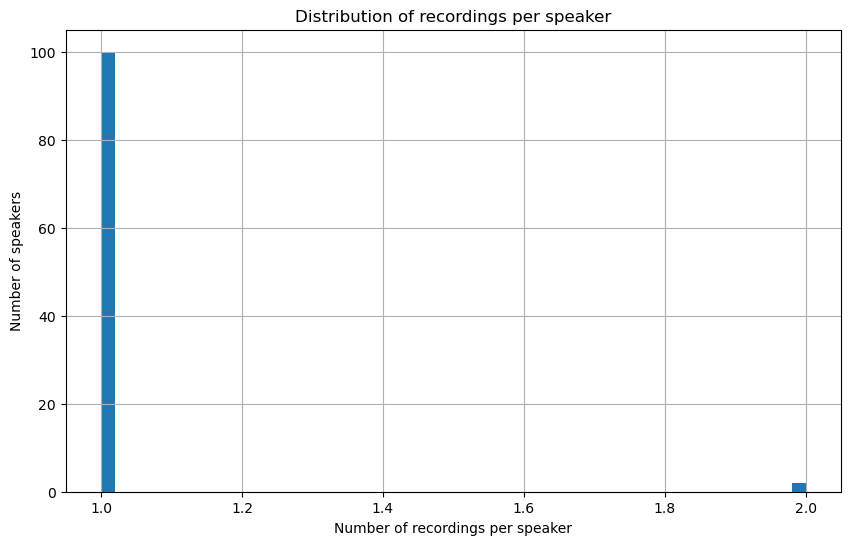

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
speaker_counts["num_recordings"].hist(bins=50)
plt.xlabel("Number of recordings per speaker")
plt.ylabel("Number of speakers")
plt.title("Distribution of recordings per speaker")
plt.show()


**This will tell you:**
Some speakers might have a lot of utterances, Others might only have a few.

In [1]:
# Use this cell in Jupyter/Colab
!pip install -qU "transformers>=4.30.0" datasets accelerate librosa soundfile jiwer evaluate peft bitsandbytes
!pip install -qU git+https://github.com/huggingface/peft.git
# ffmpeg if you need to clip audio
!apt-get update -qq && apt-get install -y -qq ffmpeg || true


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'true' is not recognized as an internal or external command,
operable program or batch file.


**Preprocessing** — downloaded files are:
data/audio/{recording_id}.wav
data/transcripts/{recording_id}.txt
Excel metadata at /mnt/data/FT Data.xlsx (adjust path if needed)

In [17]:
# === 0. Paths & params ===
EXCEL_PATH = "FT Data.xlsx"   # update if different
AUDIO_DIR = "data/audio"
TRANS_DIR = "data/transcripts"
os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs(TRANS_DIR, exist_ok=True)

# === 1. Load metadata & normalize column names ===
df_meta = pd.read_excel(EXCEL_PATH)
df_meta.columns = df_meta.columns.str.strip().str.lower()
print("Columns:", df_meta.columns.tolist())
# expected: ['user_id','recording_id','language','duration','rec_url_gcp','transcription_url_gcp','metadata_url_gcp']

# === 2. Build processed DataFrame linking audio and transcripts ===
rows = []
for _, r in df_meta.iterrows():
    rid = r["recording_id"]
    audio_path = os.path.join(AUDIO_DIR, f"{rid}.wav")
    txt_path = os.path.join(TRANS_DIR, f"{rid}.txt")
    # only keep entries that were successfully downloaded
    if not (os.path.exists(audio_path) and os.path.exists(txt_path)):
        continue
    with open(txt_path, "r", encoding="utf-8") as f:
        text = f.read().strip()
    rows.append({
        "user_id": r["user_id"],
        "recording_id": rid,
        "audio": audio_path,
        "transcription": text,
        "duration": r.get("duration", None),
        "language": r.get("language", None)
    })

df_processed = pd.DataFrame(rows)
print("Total processed examples:", len(df_processed))
df_processed.head(3)

# === 3. Text normalization (Devanagari-focused) ===
def normalize_hindi_text(text):
    # Unicode normalize, remove ASCII punctuation but keep Devanagari punctuation if needed
    text = str(text)
    text = unicodedata.normalize("NFC", text)
    # Replace common ascii punctuation with space
    text = re.sub(r"[A-Za-z0-9\[\]\(\)\{\}\<\>\@\#\$\%\^\&\*\_\=\+\|\\\/\"\'\:\;\,\?\!]", " ", text)
    # Collapse repeated whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Optionally: more advanced normalization (remove diacritics, unify nukta forms) if needed
    return text

df_processed["transcription_norm"] = df_processed["transcription"].apply(normalize_hindi_text)

# Quick check:
print(df_processed[["recording_id","transcription","transcription_norm"]].head())

# === 4. Build HF Dataset with Audio feature (16k sampling) ===
dataset = dataset.from_pandas(df_processed)
# cast audio field to Audio so librosa/torchaudio will load when mapping
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
# rename transcription column to 'sentence' or keep 'transcription'
dataset = dataset.rename_column("transcription_norm", "sentence")  # whisper examples often use 'sentence'
print(dataset)

# === 5. (Optional) split train/val if you want ===
# We will do a speaker-disjoint split to avoid same speaker in train & val:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
groups = df_processed["user_id"].fillna("unknown")
train_idx, val_idx = next(gss.split(df_processed, groups=groups))
train_df = df_processed.iloc[train_idx].reset_index(drop=True)
val_df = df_processed.iloc[val_idx].reset_index(drop=True)
train_ds = dataset.from_pandas(train_df).cast_column("audio", Audio(sampling_rate=16000)).rename_column("transcription_norm","sentence")
val_ds = dataset.from_pandas(val_df).cast_column("audio", Audio(sampling_rate=16000)).rename_column("transcription_norm","sentence")
print("Train/Val sizes:", len(train_ds), len(val_ds))


Columns: ['user_id', 'recording_id', 'language', 'duration', 'rec_url_gcp', 'transcription_url_gcp', 'metadata_url_gcp']
Total processed examples: 104
   recording_id                                      transcription  \
0        825780  [\n  {\n    "start": 0.11,\n    "end": 14.42,\...   
1        825727  [\n  {\n    "start": 0.47,\n    "end": 0.8,\n ...   
2        988596  [\n  {\n    "start": 0.53,\n    "end": 12.11,\...   
3        990175  [\n  {\n    "start": 5.51,\n    "end": 11.6,\n...   
4        526266  [\n  {\n    "start": 1.69,\n    "end": 15.7,\n...   

                                  transcription_norm  
0  . . अब काफी अच्छा होता है क्योंकि उनकी जनसंख्य...  
1  . . जी . . जी . . जी जी जी । . . जी जी जी . . ...  
2  . . लेकिन हम लोग इसे छुपछुप के लोगों के घर जाक...  
3  . . जी जी जी . . जी जी मेरे तो जैसे बहुत सारी ...  
4  . . हां जी पहले बात करते हैं विवाह की तो इस मु...  
Dataset({
    features: ['user_id', 'recording_id', 'audio', 'transcription', 'duration', 'languag

In [23]:
from datasets import Dataset, Audio

# === Save datasets to disk ===
train_ds.save_to_disk("train_dataset")
val_ds.save_to_disk("val_dataset")

print("Train and validation datasets saved!")

# === Later, to reload them ===
from datasets import load_from_disk

train_ds_loaded = load_from_disk("train_dataset")
val_ds_loaded = load_from_disk("val_dataset")

print("Reloaded train size:", len(train_ds_loaded))
print("Reloaded val size:", len(val_ds_loaded))


Saving the dataset (2/2 shards): 100%|██████████| 11/11 [00:01<00:00,  9.49 examples/s]


Train and validation datasets saved!
Reloaded train size: 93
Reloaded val size: 11
